## 频率维度

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
coor = pd.read_csv("./datasets/probe/probe0.1.csv")
coor = coor.values[:, 5:7]

In [3]:
loss_log = np.load("./checkpoint/Log_18p_pre_2k.npy", allow_pickle=True)
eq_loss = [i["eq"] for i in loss_log]
data_loss = [i["data"] for i in loss_log]
labels = [i["labels"] for i in loss_log]
out = [i["out"] for i in loss_log]
inputs = [i["input"] for i in loss_log]


In [4]:
eq_loss = np.array(eq_loss)
data_loss = np.array(data_loss)
labels = np.array(labels)
out = np.array(out)
inputs = np.array(inputs)
print("eq_loss shape:", eq_loss.shape)
print("data_loss shape:", data_loss.shape)
print("labels shape:", labels.shape)
print("out shape:", out.shape)
print("inputs shape:", inputs.shape)
loss = np.sqrt(eq_loss**2 + data_loss**2)
sum_loss = np.sum(loss, axis=1)

eq_loss shape: (2000, 3, 5094)
data_loss shape: (2000, 3, 5094)
labels shape: (2000, 5094, 3)
out shape: (2000, 5094, 3)
inputs shape: (2000, 5094, 3)


In [5]:
def pca(dataMat, n):
    """do pca"""
    p = PCA(n_components=n)
    newData = p.fit_transform(dataMat)
    return newData

In [33]:
def doNODFT(y, x_pca, freq_len=100, max_f=1):
    """
    y : 2D-array
    x_pca : 2D-array
    """
    if y.ndim == 1:
        y = np.expand_dims(y, 1).T
    x_pca = x_pca.repeat(3, 1)
    i = np.expand_dims(
        np.linspace(1 / np.pi, max_f, num=freq_len, endpoint=True), axis=1
    ).repeat(len(x_pca), 1)
    i = np.expand_dims(i, 2).repeat(len(x_pca[0]), 2)
    out = np.multiply(y, np.exp(-2 * np.pi * 1j * np.abs(x_pca) * i/10))
    out = np.average(out, axis=1)
    return out


注意：这里讨论的是响应频率，而非图像中的频率

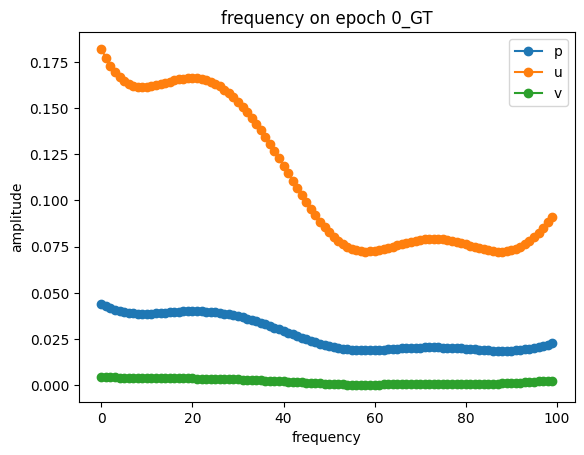

In [34]:
data_x = inputs[0]
plt.figure()
x_pca = pca(data_x, 1)
data_y = labels[0, :]  # three variables
F_y = doNODFT(data_y, x_pca)
plt.plot(np.abs(F_y), "o-", label=["p", "u", "v"])
plt.xlabel("frequency")
plt.ylabel("amplitude")
plt.legend()
plt.title("frequency on epoch 0_GT")
plt.show()


上图是真实值的频谱（注意：这里的真实值指的是采样时间点分别对应点的 p、u、v 值，所以形状为 `(length(time_array)*283,3)`）

当然，每个 epoch的真实值都是一样的

In [35]:
F_outs = []
for item in out[:100]:
    # do NUDFT for each epoch
    F_var = doNODFT(item, x_pca)
    F_outs.append(F_var)
F_outs = np.array(F_outs)


In [36]:
reletive = np.abs((F_outs - F_y) / F_y)

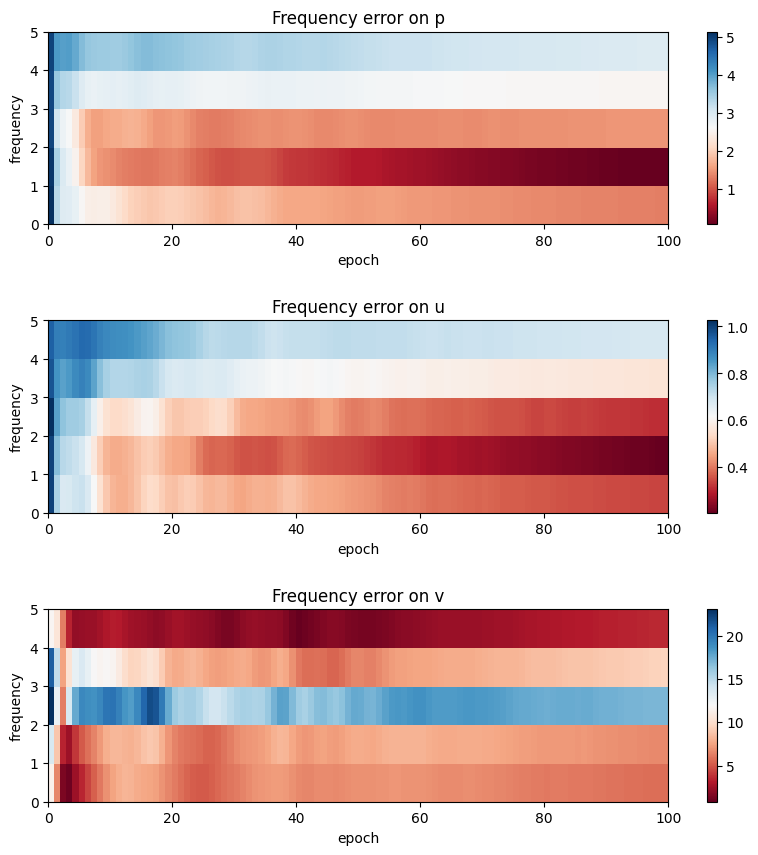

In [38]:
fig, axs = plt.subplots(3, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)
selected_index = [10, 30, 50, 70, 90]
for i in range(3):
    ax = axs[i]
    c = ax.pcolor(reletive[:, selected_index, i].T, cmap="RdBu")
    ax.set_title("Frequency error on " + ["p", "u", "v"][i])
    ax.set_xlabel("epoch")
    ax.set_ylabel("frequency")
    plt.colorbar(c, ax=ax)


上图中横坐标为训练迭代轮次，竖坐标为由小到大依次代表着低频信号到高频信号

可以看出PINN训练过程也是基本符合F频率原则的，即网络优先拟合响应函数中低频成分，然后再注意到高频成分

因为我们输入空间为高维的，所以上面方法通过 PCA 进行降维处理，即取输入空间中的一个映射，而下面通过构造一个示性函数进行处理，本质上是通过低通滤波，分离出高低成分，从而可以探讨收敛情况， 而根据频率定理，在频率空间中做乘法，相当于在时域中做卷积，所以这里的示性函数也可以看作是一个卷积核

In [14]:
def normal_kernel(diff_x2, filer_wid):
    gau_x2 = np.exp(-diff_x2 / 2 / filer_wid)
    n_con = np.sum(gau_x2, axis=1, keepdims=True)
    n_gau_x2 = gau_x2 / n_con
    return n_gau_x2

In [15]:
def gauss_filter_normalize2(f_orig, n_gau_x2):
    f_new = np.matmul(n_gau_x2, f_orig)
    return f_new

In [16]:
def compute_distances_no_loops(Y, X):
    dists = (
        -2 * np.dot(X, Y.T)
        + np.sum(Y**2, axis=1)
        + np.sum(X**2, axis=1)[:, np.newaxis]
    )
    return dists

In [17]:
def get_f_high_low(yy, xx, s_filter_wid):
    diff_x2 = compute_distances_no_loops(xx, xx)
    n_gau_x2_all = []
    for filter_wid in s_filter_wid:
        n_gau_x2 = normal_kernel(diff_x2, filter_wid)
        n_gau_x2_all.append(n_gau_x2)
    f_low = []
    f_high = []
    for filter_wid_ind in range(len(s_filter_wid)):
        f_new_norm = gauss_filter_normalize2(yy, n_gau_x2_all[filter_wid_ind])
        f_low.append(f_new_norm)
        f_high_tmp = yy - f_new_norm
        f_high.append(f_high_tmp)
    return f_low, f_high


得到gt的高低频成分

In [18]:
f_gt = []
x = inputs[0]
for i in range(3):
    y = labels[0, :, i]
    y = np.expand_dims(y, 1)
    low, high = get_f_high_low(y, x, [0.1])
    f_gt.append(np.array([low[0], high[0]]))
f_gt = np.array(f_gt).squeeze()
print(f_gt.shape)


(3, 2, 5094)


In [19]:
f_y = []
for item in out[:100]:
    temp = []
    for var in range(3):
        y = item[:, i]
        y = np.expand_dims(y, 1)
        low, high = get_f_high_low(y, x, [1 / np.pi])
        temp.append(np.array([low, high]))
    f_y.append(np.array(temp))
f_y = np.array(f_y).squeeze()

In [20]:
eoor = np.sum(np.abs(f_gt - f_y) ** 2, axis=-1) / np.sum(np.abs(f_gt) ** 2, axis=-1)
eoor = np.sqrt(eoor)

/var/folders/63/2wdldz3j39sc4tvvxw_z7bq00000gn/T/ipykernel_3843/2224539786.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", "low", "", "high"])


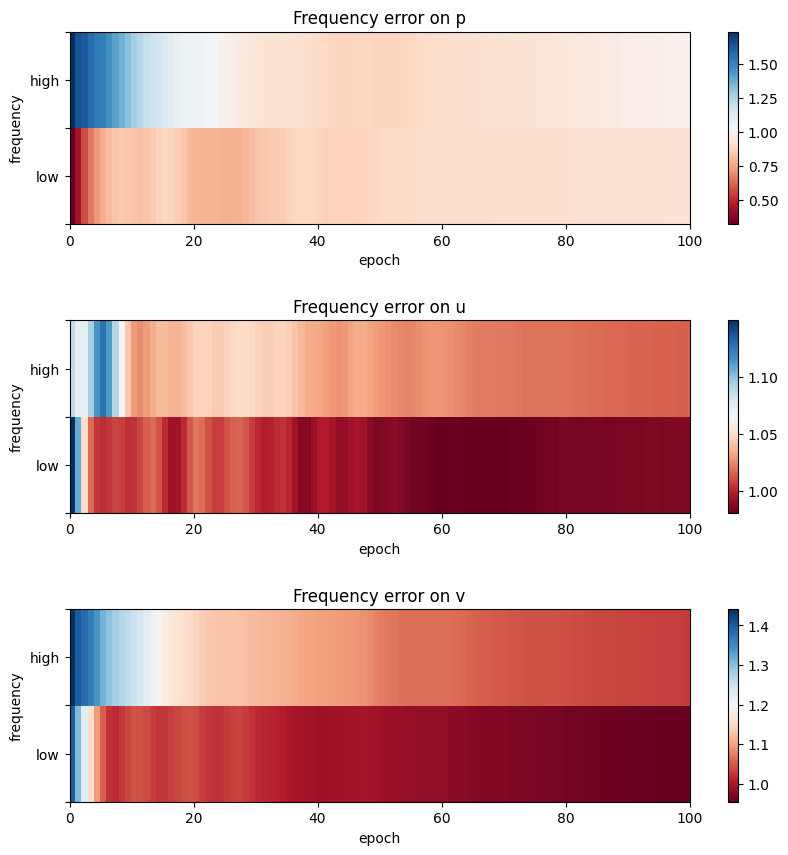

In [21]:
eoor = np.squeeze(eoor)
fig, axs = plt.subplots(3, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(3):
    ax = axs[i]
    c = ax.pcolor(eoor[:, i, :].T, cmap="RdBu")
    ax.set_title("Frequency error on " + ["p", "u", "v"][i])
    ax.set_xlabel("epoch")
    ax.set_ylabel("frequency")
    ax.set_yticklabels(["", "low", "", "high"])
    plt.colorbar(c, ax=ax)

上图展示了使用示性函数方法得到在高低频上的收敛情况

同样的也是低频成分先收敛